In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
import pandas as pd
key = random.PRNGKey(0)

from utils import biaxial_relax, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_gov_vmap, dPhi_vmap, plot45

In [2]:
# Functions for training
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 


# Define loss functions
def biaxial_relax_loss(params, norm, useNODE, inp, out):
    sigma_pr,_,_,_,_,_,_ = biaxial_relax(params, norm, useNODE, inp[0], inp[1], inp[2])
    loss = np.mean((sigma_pr[:,0,0]-out[0])**2)# + (sigma_pr[:,1,1]-out[1])**2)
    return loss
biaxial_relax_loss_vmap = vmap(biaxial_relax_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
biaxial_relax_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(biaxial_relax_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.mean((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.mean((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.mean((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.mean((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.mean((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.mean((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

# 1. Train Govindjee's model

In [3]:
with open('training_data/manu_bloodclots_short.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)

In [4]:
# Initial guesses for material parameters
mu = 77.77*0.1
K = 1.0
gov_Psi_eq_params = [K, mu]
gov_Psi_neq_params = [K, mu]

eta_D = 1360.0
eta_V = 175000.0
gov_Phi_params = [np.log(eta_D*0.1), np.log(eta_V*0.1)]

gov_params = [gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params]
gov_norm = (1.0, 1.0, 1.0)

In [5]:
lr = 1.0e-3
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(gov_params)

ids = [1]
inp = np.array([time[ids], lmb_x[ids], lmb_y[ids]]).transpose([1,0,2])
out = np.array([sgm_x[ids], sgm_y[ids]]).transpose([1,0,2])
gov_params, train_loss, val_loss = train(inp, out, gov_norm, False, opt_state, key, biaxial_relax_batch_loss, nIter = 12000, batch_size=1, print_freq=100)
    
with open('saved/bc_VTV_gov_params.npy', 'wb') as f:
    pickle.dump(gov_params, f)

it 0, train loss = 2.857337e+00
it 100, train loss = 2.497101e+00
it 200, train loss = 2.184728e+00
it 300, train loss = 1.911632e+00
it 400, train loss = 1.669703e+00
it 500, train loss = 1.444089e+00
it 600, train loss = 3.996082e-01
it 700, train loss = 3.225849e-01
it 800, train loss = 2.786239e-01
it 900, train loss = 2.432278e-01
it 1000, train loss = 2.138690e-01
it 1100, train loss = 1.891356e-01
it 1200, train loss = 1.680867e-01
it 1300, train loss = 1.500376e-01
it 1400, train loss = 1.344658e-01
it 1500, train loss = 1.209611e-01
it 1600, train loss = 1.091955e-01
it 1700, train loss = 9.890321e-02
it 1800, train loss = 8.986650e-02
it 1900, train loss = 8.190574e-02
it 2000, train loss = 7.487149e-02
it 2100, train loss = 6.863858e-02
it 2200, train loss = 6.310160e-02
it 2300, train loss = 5.817122e-02
it 2400, train loss = 5.377136e-02
it 2500, train loss = 4.983687e-02
it 2600, train loss = 4.631175e-02
it 2700, train loss = 4.314758e-02
it 2800, train loss = 4.030239e-

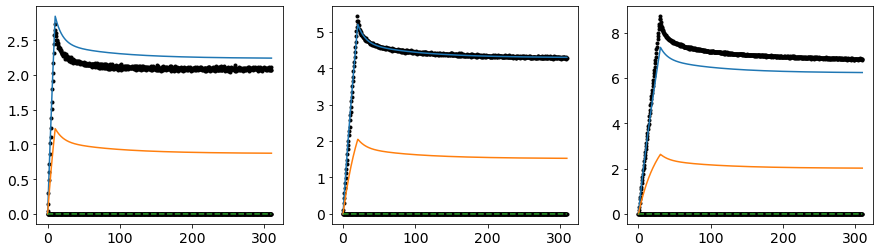

In [6]:
fig, ax = plt.subplots(1,3,figsize=[15,4])
for i in range(3):
    sigm_pr, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_relax(gov_params, gov_norm, False, time[i], lmb_x[i], lmb_y[i])

    ax[i].plot(time[0],sgm_x[i],'k.')
    ax[i].plot(time[0],sgm_y[i],'k.')
    ax[i].plot(time[0],sigm_pr[:,0,0])
    ax[i].plot(time[0],sigm_pr[:,1,1])
    ax[i].plot(time[0],sigm_pr[:,2,2], '--')

# 2. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [7]:
with open('saved/bc_VTV_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params

In [8]:
# Generate training data
# Inputs
lm = np.linspace(0.7,1.4,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_eq_params)

## 2.1 $\Psi_{EQ}$

In [9]:
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = gov_Psi_eq_params
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)
    
with open('saved/bc_VTV_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 1.554285e+02
it 10000, train loss = 9.976505e-03
it 20000, train loss = 4.530855e-04
it 30000, train loss = 1.512786e-04
it 40000, train loss = 7.069038e-05
it 50000, train loss = 2.982055e-05
it 60000, train loss = 1.093072e-05
it 70000, train loss = 1.294135e-05
it 80000, train loss = 5.826018e-06
it 90000, train loss = 3.930229e-06
it 100000, train loss = 1.411881e-06
it 110000, train loss = 1.529456e-06
it 120000, train loss = 1.647684e-06
it 130000, train loss = 7.001749e-07
it 140000, train loss = 4.858932e-07
it 150000, train loss = 2.110393e-06
it 160000, train loss = 1.757222e-06
it 170000, train loss = 4.622151e-07
it 180000, train loss = 2.324256e-07
it 190000, train loss = 5.606995e-07
it 200000, train loss = 6.134171e-07


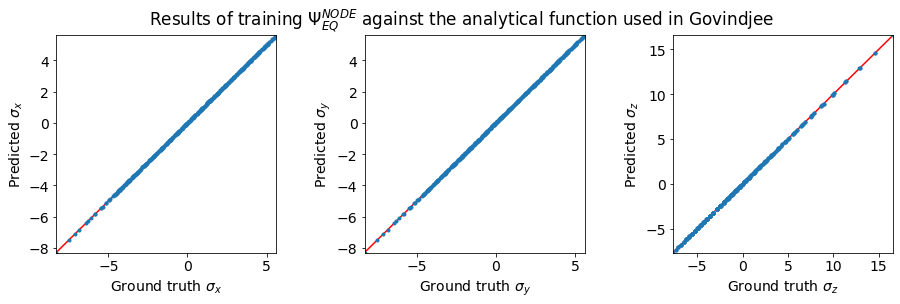

In [10]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 2.2 $\Psi_{NEQ}$

In [11]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = gov_Psi_neq_params
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)

with open('saved/bc_VTV_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 2.247680e+02
it 10000, train loss = 3.834350e-02
it 20000, train loss = 4.913800e-04
it 30000, train loss = 1.473326e-04
it 40000, train loss = 5.083368e-05
it 50000, train loss = 1.742264e-05
it 60000, train loss = 5.349433e-06
it 70000, train loss = 2.591691e-06
it 80000, train loss = 1.545932e-06
it 90000, train loss = 5.690362e-07
it 100000, train loss = 2.576695e-07
it 110000, train loss = 4.451641e-07
it 120000, train loss = 1.006158e-07
it 130000, train loss = 4.001253e-08
it 140000, train loss = 2.525062e-07
it 150000, train loss = 6.788576e-08
it 160000, train loss = 1.843044e-08
it 170000, train loss = 6.610782e-09
it 180000, train loss = 5.321281e-09
it 190000, train loss = 2.606983e-06
it 200000, train loss = 4.767652e-09


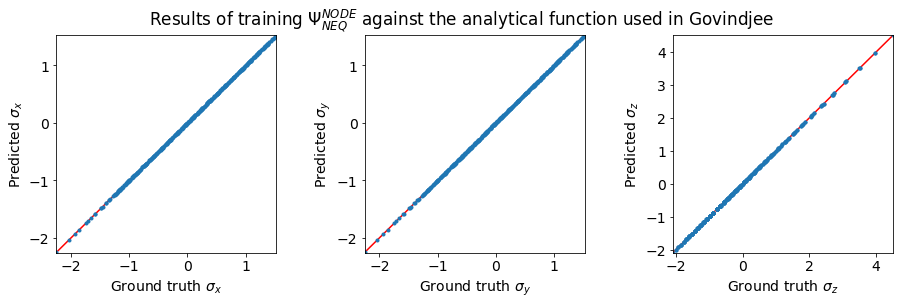

In [12]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 3. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [13]:
with open('saved/bc_VTV_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params
eta_D, eta_V = gov_Phi_params

In [14]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-10.0:10.0:10j, -10.0:10.0:10j, -10.0:10.0:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

# inp_std1 = onp.std(tau1)
# inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

# out_std1 = 1.0
# out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [15]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 100000, batch_size=100, print_freq=10000)

with open('saved/bc_VTV_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/bc_VTV_Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 7.675313e+00
it 10000, train loss = 2.548726e-01
it 20000, train loss = 1.490195e-01
it 30000, train loss = 6.508184e-02
it 40000, train loss = 1.693993e-04
it 50000, train loss = 4.468378e-05
it 60000, train loss = 4.391254e-05
it 70000, train loss = 4.319210e-05
it 80000, train loss = 4.306706e-05
it 90000, train loss = 4.307677e-05
it 100000, train loss = 4.304379e-05


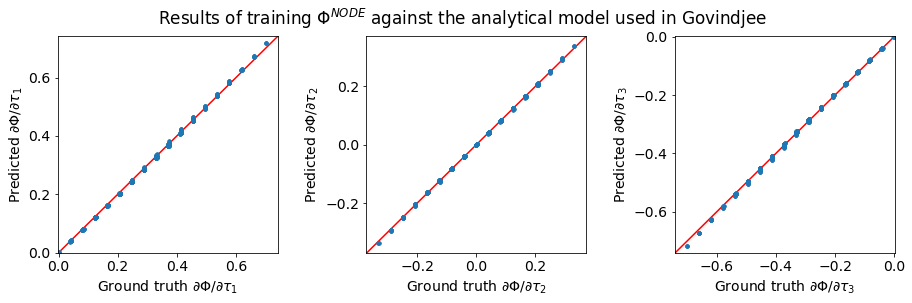

In [16]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Test

In [20]:
#Load the pre-trained parameters
with open('saved/bc_VTV_Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/bc_VTV_Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/bc_VTV_Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/bc_VTV_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('training_data/manu_bloodclots_short.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)

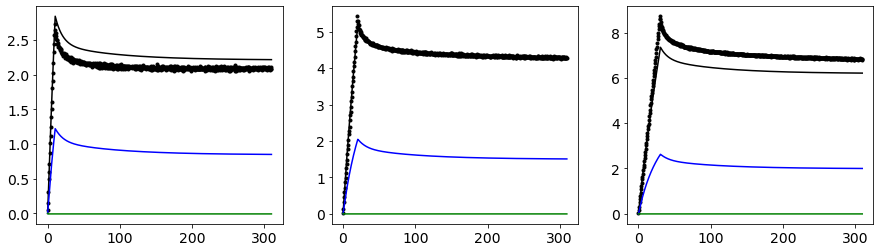

In [21]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

for i in range(3):
    t = time[0]
    sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_relax(params, norm, True, t, lmb_x[i],lmb_y[i])

    ax[i].plot(t, sgm_x[i], 'k.')
    ax[i].plot(t,sig_NN[:,0,0],'k-')
    ax[i].plot(t,sig_NN[:,1,1],'b-')
    ax[i].plot(t,sig_NN[:,2,2],'g-')

# 5. Retrain

In [23]:
opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(params)

ids = [1]
inp = np.array([time[ids], lmb_x[ids], lmb_y[ids]]).transpose([1,0,2])
out = np.array([sgm_x[ids], sgm_y[ids]]).transpose([1,0,2])

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, biaxial_relax_batch_loss, nIter = 1000, batch_size=1, print_freq=100)

with open('saved/bc_VTV_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

plt.plot(train_loss)

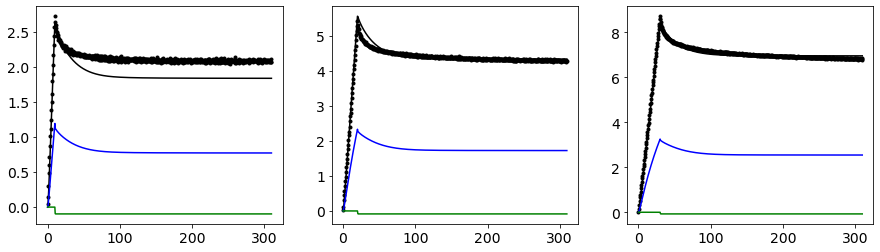

In [10]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

for i in range(3):
    t = time[0]
    sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_relax(params, norm, True, t, lmb_x[i],lmb_y[i])

    ax[i].plot(t, sgm_x[i], 'k.')
    ax[i].plot(t,sig_NN[:,0,0],'k-')
    ax[i].plot(t,sig_NN[:,1,1],'b-')
    ax[i].plot(t,sig_NN[:,2,2],'g-')

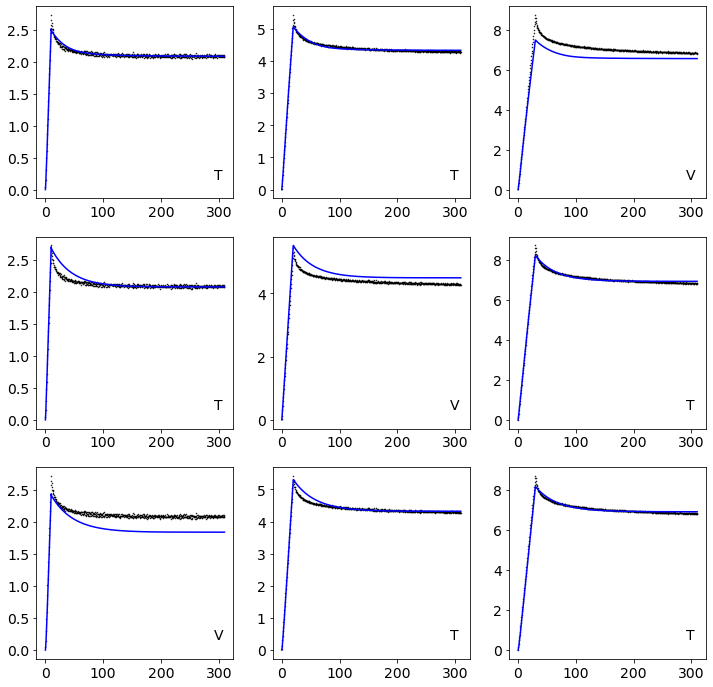

In [13]:
# Save data for TikZ
fig, ax = plt.subplots(3,3,figsize=(12,12))
with open('training_data/manu_bloodclots_short.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)
labelset = ['abc', 'def', 'ghi']
cases = ['TTV', 'TVT', 'VTT']
t = time[0]
for label, case, axi in zip(labelset, cases, ax):
    with open('saved/bc_'+case+'_params_retrained.npy', 'rb') as f:
        params = pickle.load(f)
    with open('saved/bc_'+case+'_Phi_norm_w.npy', 'rb') as f:
        Phi_norm = pickle.load(f)
        norm = (None, None, Phi_norm)
    for i in range(3):
        sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_relax(params, norm, True, t, lmb_x[i],lmb_y[i])
        axi[i].plot(t, sgm_x[i], 'k.', markersize=1)
        axi[i].plot(t,sig_NN[:,0,0],'b-')
        # axi[i].plot(t,sig_NN[:,1,1],'b-')
        # axi[i].plot(t,sig_NN[:,2,2],'g-')
        axi[i].text(0.9,0.1,case[i],transform=axi[i].transAxes)

        #Save to TikZ
        header = ['x', 'y_gt', 'y_pr']
        df = pd.DataFrame(np.array([t, sgm_x[i], sig_NN[:,0,0]], dtype=np.float16).T, columns=header)
        df.to_csv('tikz_data/fig_bc/fig_bc_'+label[i]+'.csv', index=False, sep=' ')

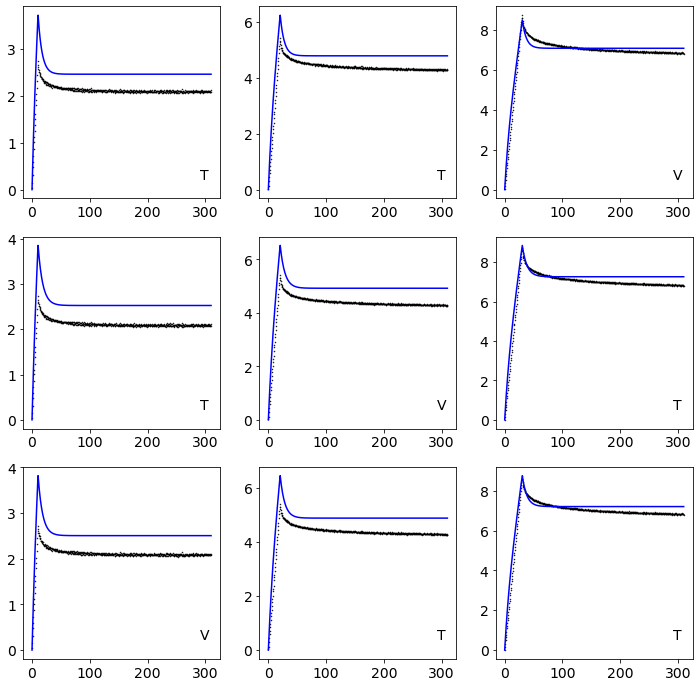

In [7]:
# Save data for TikZ
import pandas as pd
fig, ax = plt.subplots(3,3,figsize=(12,12))
labelset = ['abc', 'def', 'ghi']
cases = ['TTV', 'TVT', 'VTT']
t = time[0]
for label, case, axi in zip(labelset, cases, ax):
    with open('saved/bc_'+case+'_gov_params.npy', 'rb') as f:
        gov_params = pickle.load(f)
    with open('saved/bc_'+case+'_Phi_norm_w.npy', 'rb') as f:
        Phi_norm = pickle.load(f)
        norm = (None, None, Phi_norm)
    for i in range(3):
        sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_relax(gov_params, norm, False, t, lmb_x[i],lmb_y[i])
        axi[i].plot(t, sgm_x[i], 'k.', markersize=1)
        axi[i].plot(t,sig_NN[:,0,0],'b-')
        axi[i].text(0.9,0.1,case[i],transform=axi[i].transAxes)

        #Save to TikZ
        header = ['x', 'y_gt', 'y_pr']
        df = pd.DataFrame(np.array([t, sgm_x[i], sig_NN[:,0,0]], dtype=np.float16).T, columns=header)
        df.to_csv('tikz_data/fig_bc/fig_bc_gov_'+label[i]+'.csv', index=False, sep=' ')

In [15]:
# Errors
cases = ['TTV', 'TVT', 'VTT']
training = [[0,1], [0,2], [1,2]]
validation = [2,1,0]
labelset = ['abc', 'def', 'ghi']
for case, trn, val, label in zip(cases, training, validation, labelset):
    mae = onp.zeros(3)
    mre = onp.zeros(3)
    data0 = pd.read_csv('tikz_data/fig_bc/fig_bc_'+label[0]+'.csv', sep=' ')
    mae[0] = onp.mean(onp.abs(data0.y_gt-data0.y_pr))
    mre[0] = onp.mean(onp.abs((data0.y_gt-data0.y_pr)/data0.y_gt))
    
    data1 = pd.read_csv('tikz_data/fig_bc/fig_bc_'+label[1]+'.csv', sep=' ')
    mae[1] = onp.mean(onp.abs(data1.y_gt-data1.y_pr))
    mre[1] = onp.mean(onp.abs((data1.y_gt-data1.y_pr)/data1.y_gt))

    data2 = pd.read_csv('tikz_data/fig_bc/fig_bc_'+label[2]+'.csv', sep=' ')
    mae[2] = onp.mean(onp.abs(data2.y_gt-data2.y_pr))
    mre[2] = onp.mean(onp.abs((data2.y_gt-data2.y_pr)/data2.y_gt))

    mae_trn = mae[trn]
    mae_val = mae[val]
    mre_trn = mre[trn]
    mre_val = mre[val]
    print('-------')
    print('case ', case)
    print('Training MAE = ', onp.mean(mae_trn))
    print('Training MRE = ', onp.mean(mre_trn))
    print('Validation MAE = ', onp.mean(mae_val))
    print('Validation MRE = ', onp.mean(mre_val))

-------
case  TTV
Training MAE =  0.03274343800322064
Training MRE =  0.015265628525273873
Validation MAE =  0.43722256038647367
Validation MRE =  0.06991278931111944
-------
case  TVT
Training MAE =  0.05563870370370373
Training MRE =  0.01931902483158717
Validation MAE =  0.19281399355877624
Validation MRE =  0.04731603109249218
-------
case  VTT
Training MAE =  0.07037028985507243
Training MRE =  0.021280518837676385
Validation MAE =  0.20902112721417074
Validation MRE =  0.10531061993849059
